# MCA: Multiple Correspondence Analysis

In [2]:
import json
import pandas as pd
# ! pip install prince
import prince
from sklearn.preprocessing import OneHotEncoder
import itertools

In [3]:
omdb = json.load(open("../../../../data/parsed/omdb.json", "r") )
tmdb = json.load(open("../../../../data/parsed/tmdb.json", "r") )

In [4]:
categorical = {
    'omdb': ['Rated', 'Director', 'Genre', 'Language', 'Country', 'Type', 'Production'],
}

In [5]:
def apply_categorical(records, type, take):
    res = {i: {} for i in records.keys()}
    for row in records.keys():
        for col in records[row][type].keys():
            if col in take:
                res[row][col] = records[row][type][col]
    return res

def apply_split(records, split, limit):
    for row in records.keys():
        for col in split:
            records[row][col] = tuple(records[row][col].split(', '))
    return records

In [6]:
cat = apply_categorical(omdb, 'omdb', categorical['omdb'])
cat = apply_split(cat, ['Country', 'Language', 'Genre'], 3)
catdf = pd.DataFrame.from_dict(cat).T

### TopK One Hot

In [7]:
def one_hot(arr, name, categories):
    return dict((name+i, i in arr) for i in categories)

def apply_one_hot(records, type, name, categories):
    for row in records.keys():
        records[row] = {**records[row], **one_hot(records[row][type], name, categories)}
        del records[row][type]
    return records

genres_cat = list(set(itertools.chain(*tuple(catdf.Genre.unique()))))
language_cat = pd.Series(list(itertools.chain(*catdf.Language))).value_counts()[:30].index
countries_cat = pd.Series(list(itertools.chain(*catdf.Country))).value_counts()[:30].index

cat = apply_one_hot(cat, 'Genre', 'g_', genres_cat)
cat = apply_one_hot(cat, 'Country', 'c_', countries_cat)
cat = apply_one_hot(cat, 'Language', 'l_', language_cat)

In [8]:
catdf = pd.DataFrame.from_dict(cat).T
catdf.Rated = catdf.Rated.fillna('Not rated')
catdf.Rated[catdf.Rated == 'N/A'] = 'Not rated'
catdf.Production.fillna('-')
catdf.Production[catdf.Production == 'N/A'] = '-'
catdf.Production[catdf.Production == 'NaN'] = '-'
catdf.Production[catdf.Production.isna()] = '-'
catdf.Director.fillna('-')
catdf.Director[catdf.Director == 'N/A'] = '-'
catdf

,Director,Production,Rated,Type,c_Argentina,c_Australia,c_Austria,c_Belgium,c_Brazil,c_Canada,...,l_Norwegian,l_Persian,l_Polish,l_Portuguese,l_Romanian,l_Russian,l_Spanish,l_Swedish,l_Thai,l_Turkish
1,John Lasseter,Buena Vista,G,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Joe Johnston,Sony Pictures Home Entertainment,PG,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Howard Deutch,Warner Home Video,PG-13,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Forest Whitaker,Twentieth Century Fox Home Entertainment,R,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,Charles Shyer,Disney,PG,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,Michael Mann,Warner Bros.,R,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
7,Sydney Pollack,Paramount,PG,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,Peter Hewitt,Buena Vista,PG,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,Peter Hyams,MCA Universal Home Video,R,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,Martin Campbell,MGM/UA,PG-13,movie,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False


In [9]:
mca = prince.MCA(
        n_components=16,
        n_iter=20,
        copy=True,
        check_input=True,
        engine='auto',
)
mca = mca.fit(catdf)

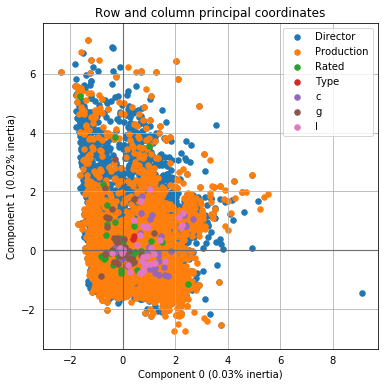

In [10]:
%matplotlib inline
ax = mca.plot_coordinates(
        X=catdf,
        ax=None,
        figsize=(6, 6),
        show_row_points=True,
        row_points_size=10,
        show_row_labels=False,
        show_column_points=True,
        column_points_size=30,
        show_column_labels=False,
        legend_n_cols=1
)

In [11]:
mca.total_inertia_

172.20652173913044

In [12]:
mca.explained_inertia_

[0.00031004349235490096,
 0.00024407550680482484,
 0.00024224621326650363,
 0.00022814856784999016,
 0.00021930476271940562,
 0.00021304027854409944,
 0.0002072674142380232,
 0.000199432892496279,
 0.00019403973358031934,
 0.0001918116400945375,
 0.00018776010984336986,
 0.00018602847102141027,
 0.0001828780979726546,
 0.00017723680151436515,
 0.00017292846804856357,
 0.00017174537602483142]

In [13]:
transformed = mca.transform(catdf)

In [16]:
transformed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,-0.315033,0.887990,-0.270987,-0.325338,-0.127576,0.127343,-0.350190,0.133135,0.040275,-0.037793,0.218587,-0.143559,-0.030916,0.082654,-0.024376,-0.007475
2,-0.232859,0.302867,-0.093848,-0.123506,-0.081838,0.144027,-0.220983,0.054143,0.068112,-0.010963,0.071377,-0.050882,-0.082761,-0.034340,-0.048776,0.009969
3,-0.113806,-0.092889,-0.069016,-0.066530,-0.002579,-0.008651,-0.137804,0.046271,0.092878,0.023162,-0.084194,0.000369,-0.008009,0.075603,-0.067614,0.005408
4,-0.162537,-0.096028,-0.038393,0.023750,0.040468,-0.036200,-0.083324,0.056271,0.104728,0.006673,-0.104419,0.042681,0.035876,-0.052178,0.102436,-0.011493
5,-0.247296,0.198796,-0.150033,-0.083669,0.018020,-0.028111,-0.229754,0.093666,0.112904,-0.011536,-0.006166,0.014937,0.018378,-0.029215,0.023968,-0.037082


In [17]:
transformed.to_csv('../../../../data/engineering/mca.csv', index=True, index_label='idx')

# Probabilistic PCA with missing data

In [18]:
import json
import pandas as pd
# ! pip install ppca
import ppca
import numpy as np

In [19]:
omdb = json.load(open("../../../../data/parsed/omdb.json", "r") )
tmdb = json.load(open("../../../../data/parsed/tmdb.json", "r") )

In [20]:
numerical = {
    'omdb': ['Year', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes'],
    'tmdb': ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
}

In [21]:
def apply_numerical(records, type, take):
    res = {i: {} for i in records.keys()}
    for row in records.keys():
        for col in records[row][type].keys():
            if col in take:
                res[row][col] = records[row][type][col]
    return res

def apply_ratings(records):
    res = records.copy()
    for i in res.keys():
        for rating in res[i]['Ratings']:
            res[i]['r ' + rating['Source']] = rating['Value']
        del res[i]['Ratings']
    return res

In [22]:
numo = apply_numerical(omdb, 'omdb', numerical['omdb'])
numt = apply_numerical(tmdb, 'tmdb', numerical['tmdb'])
num = dict([(i, {**numo[i], **numt[i]}) for i in numo.keys()])
num = apply_ratings(num)

In [23]:
numdf = pd.DataFrame.from_dict(num).T
for col in numdf.columns:
    numdf[col].loc[numdf[col] == 'N/A'] = np.nan
numdf['budget'] = numdf['budget'].replace(to_replace=0, value=np.nan)
numdf['r Internet Movie Database'].loc[numdf['r Internet Movie Database'].notnull()] = \
numdf['r Internet Movie Database'].loc[numdf['r Internet Movie Database'].notnull()].apply(lambda x: x.split('/')[0])
numdf['r Metacritic'].loc[numdf['r Metacritic'].notnull()] = \
numdf['r Metacritic'].loc[numdf['r Metacritic'].notnull()].apply(lambda x: int(x.split('/')[0]))
numdf['r Rotten Tomatoes'].loc[numdf['r Rotten Tomatoes'].notnull()] = \
numdf['r Rotten Tomatoes'].loc[numdf['r Rotten Tomatoes'].notnull()].apply(lambda x: float(x.replace('%', '')))
numdf['revenue'] = numdf['revenue'].replace(to_replace=0, value=np.nan)
numdf['Year'].loc[numdf['Year'].notnull()] = numdf['Year'].loc[numdf['Year'].notnull()].apply(lambda x: int(x.replace('–', '')[0]))
numdf['imdbVotes'].loc[numdf['imdbVotes'].notnull()] = numdf['imdbVotes'].loc[numdf['imdbVotes'].notnull()].apply(lambda x: int(x.replace(',', ''))) 

/home/dev/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
numdf.head()

,Metascore,Year,budget,imdbRating,imdbVotes,popularity,r Internet Movie Database,r Metacritic,r Rotten Tomatoes,revenue,runtime,vote_average,vote_count
1,95,1,30000000.0,8.3,810875,29.3,8.3,95,100,373554033.0,81,7.9,10896
2,39,1,65000000.0,7.0,274701,5.882,7.0,39,54,262797249.0,104,7.2,6263
3,46,1,NaN,6.6,22581,8.321,6.6,46,17,NaN,101,6.6,166
4,NaN,1,16000000.0,5.9,8833,5.554,5.9,NaN,56,81452156.0,127,6.1,61
5,49,1,NaN,6.0,31738,10.859,6.0,49,48,76578911.0,106,6.1,332


In [25]:
from ppca import PPCA
ppca = PPCA()
ppca.fit(data=numdf.values.astype(float), d=16, verbose=True)
ppca.var_exp

1.0
0.41005684174738144
0.2324617520036919
0.0857667976041836
0.022545972381646018
0.0015108708361569745
0.0032686347458421583
0.0031287822969590096
0.0018176956559194934
0.0005005760755345534
0.00050488347032418
0.001157858342654916
0.0015101342558477837
0.0016388741767462411
0.001618030083341604
0.001507341873176249
0.0013503707715412094
0.0011765120711065835
0.0010041854780884485
0.0008439240065923892
0.000700912173653534
0.0005769019724580771
0.00047157999742220014
0.0003834992299667217
0.0003106864478251703
0.00025101871010535515
0.00020244176625461296
0.0001630843372523172
0.00013130664815441673
0.00010570956166489065
8.512178605601939e-05


array([0.41611336, 0.67291073, 0.76276352, 0.84822885, 0.89925732,
       0.93159397, 0.95743344, 0.97933814])

In [37]:
transformed = ppca.transform()
transformed = pd.DataFrame(transformed)
transformed['idx'] = pd.Series(list(omdb.keys()))
transformed = transformed.set_index('idx')

In [38]:
transformed.head()

,0,1,2,3,4,5,6,7
idx,,,,,,,,
1,7.453023,12.545716,1.467194,4.227465,1.540035,-1.580889,0.639599,2.645455
2,1.175436,5.429367,1.257749,1.385512,1.000995,-2.348487,-2.097918,-0.272368
3,-0.785902,0.535021,1.054240,-0.004152,-0.864204,0.654745,-1.207935,-0.033078
4,-0.678476,0.010564,1.269226,-0.804065,-0.233536,-0.128752,0.253623,0.050056
5,-0.754033,0.916318,1.173397,-0.018318,-0.737318,0.722608,0.117330,-0.078719


In [39]:
transformed.to_csv('../../../../data/engineering/pca.csv', index=True, index_label='idx')

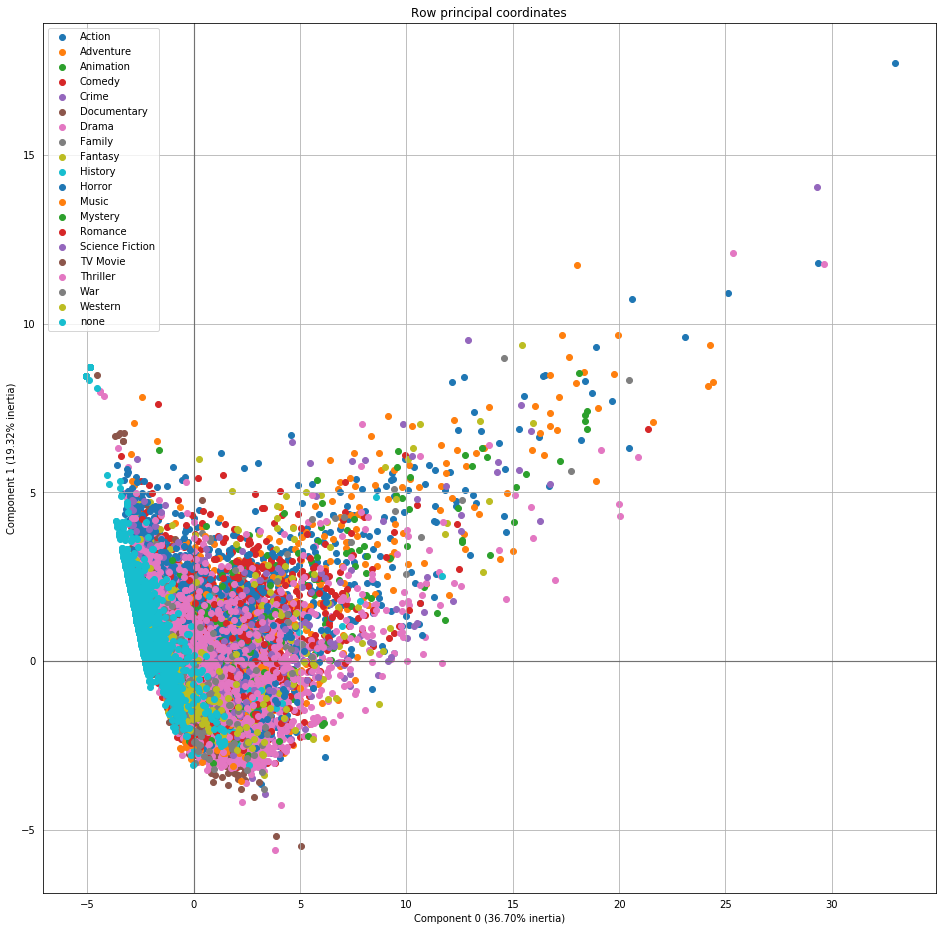

In [140]:
# Bonus: Prince's PCA visualization
# Unfortunately, Prince does not work with missing data
# So you need to use PCA Magic instead

# UMAP: Uniform Manifold Approximation and Projection
P.S. As for now, I am using this as a proof of concept for numerical feature visualization

It does not support NaN values, hence my main focus for numerics is Probabilistic PCA

In [59]:
# Get Rid of NaNs
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
numdf = numdf.astype(float)
imputer = imputer.fit(numdf)
numdf = imputer.transform(numdf)

In [75]:
# pretty colors
color = []
for row in tmdb.keys():
    genres = tmdb[row]['tmdb'].get('genres', False)
    if genres:
        color.append(genres[0]['id'])
    else:
        color.append('0')
le = preprocessing.LabelEncoder()
color = le.fit_transform(color)

In [81]:
import warnings
warnings.filterwarnings('ignore')


import umap
embedding = umap.UMAP(n_neighbors=100, min_dist=0.3).fit_transform(numdf)

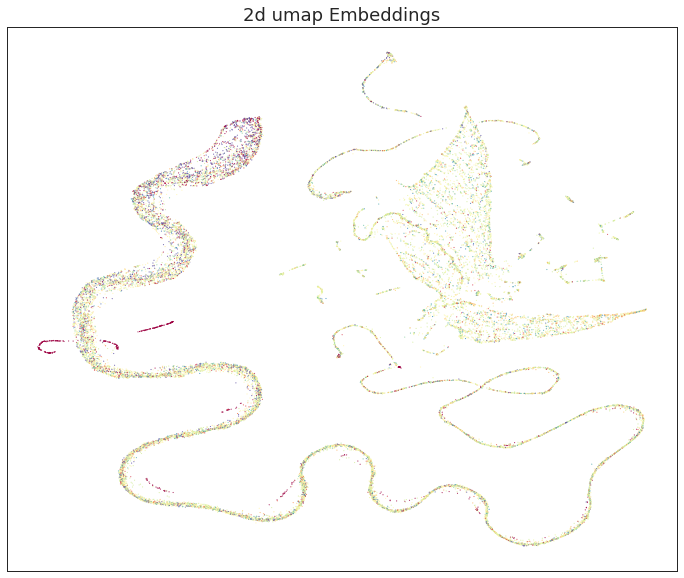

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline
sns.set(context="paper", style="white")


# color = cm.rainbow(color)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("2d umap Embeddings", fontsize=18)

plt.show()